In [67]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as sts

In [68]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

In [69]:
import datetime as dt2

# Reflect Tables into SQLAlchemy ORM

In [70]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [71]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [72]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [73]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [74]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [75]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [76]:
# View record structure
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1895c88fc18>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

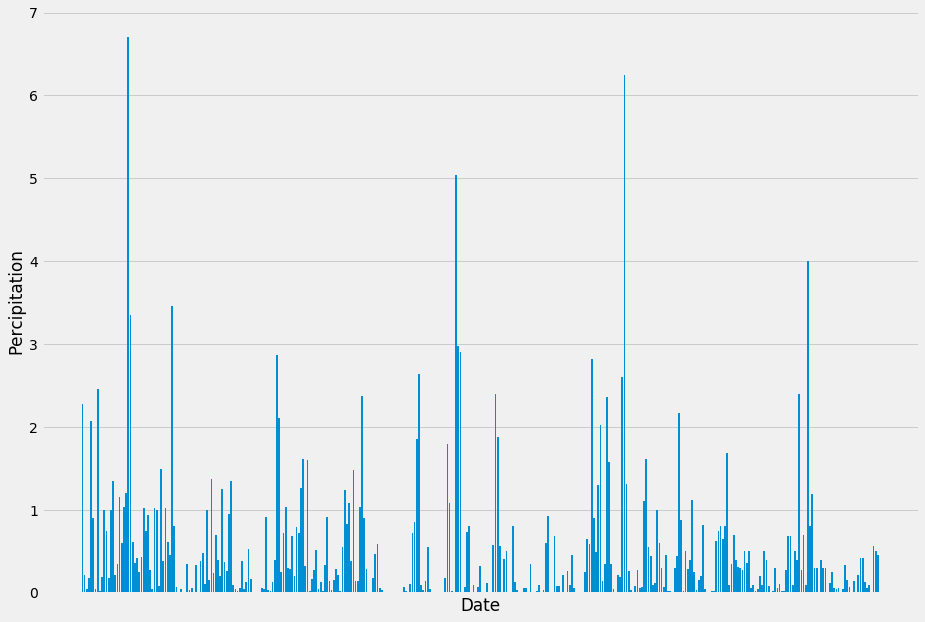

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

maxdate = str(maxdate)

maxdate = maxdate.split("'")[1]

datetime_object = dt.strptime(maxdate, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
twelve_months = datetime_object - dt2.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
percip = session.query(Measurement.date, Measurement.prcp).filter((Measurement.date) >= twelve_months).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(percip)
df.head()

df.set_index('date', inplace=True)
df.head()

# Sort the dataframe by date
df.sort_index(inplace=True)
df.head()

# Drop NaN
df = df.dropna()
df

# Use Pandas Plotting with Matplotlib to plot the data
x_pos = df.index
y_pos = df.prcp
plt.figure(figsize=(14,10))
plt.bar(x_pos, y_pos)
plt.xlabel("Date")
plt.ylabel("Percipitation")
plt.xticks([])
plt.show()

![precipitation](Images/precipitation.png)

In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [79]:
# View record structure
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1895c88fd30>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0}

In [80]:
# Looking at the stations table to find number of stations
stations = session.query(Station.id).count()
print(f"There are {stations} stations recording weather measurements.")

There are 9 stations recording weather measurements.


In [81]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {number_stations} stations recording weather measurements.")

There are 9 stations recording weather measurements.


In [82]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
max_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
max_station = (max_station[0])
print(max_station)

station_records = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_records

USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
records = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == max_station).all()
print(records)

records = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == max_station).all()
print(records)

records = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == max_station).all()
print(records)

[('USC00519281', 85.0)]
[('USC00519281', 54.0)]
[('USC00519281', 71.66378066378067)]


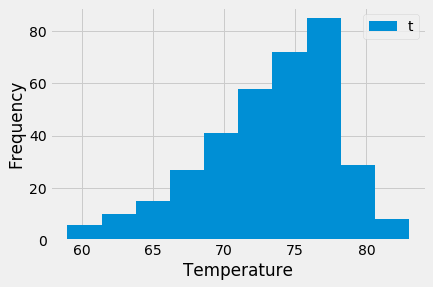

In [84]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp = session.query(Measurement.tobs).filter((Measurement.date) >= twelve_months).filter((Measurement.station) == max_station).all()
station_temp
station_temp = pd.DataFrame(station_temp)

plt.hist("tobs", data=station_temp)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend('tobs')



![precipitation](Images/station-histogram.png)

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [86]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = '2017-03-10 to \n 2017-04-01'
trip_df = (calc_temps('2017-03-10', '2017-04-01'))
print(trip_df)

[(65.0, 73.20714285714286, 82.0)]


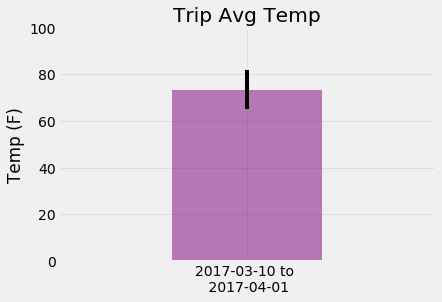

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_df[0][0]
avg_temp = trip_df[0][1]
max_temp = trip_df[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

errorBars = np.array([[min_error], [max_error]])

plt.bar(trip_dates, avg_temp, color = 'purple', alpha = .5, yerr=errorBars)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.5)

In [121]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

min_date = '2017-03-10'
max_date = '2017-04-01'


Total_prcp = session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= min_date).filter(Measurement.date <= max_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall = pd.DataFrame(Total_prcp, columns = ['station','Total Rainfall'])
total_rainfall.head()

Stations_tbl = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
stations_df = pd.DataFrame(Stations_tbl)
stations_df.head()

merge_df = total_rainfall.merge(stations_df, how = 'left', on='station')
merge_df

,station,Total Rainfall,name,latitude,longitude,elevation
0,USC00519281,1.66,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00516128,1.63,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00513117,1.19,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,0.95,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,0.40,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00517948,0.06,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [65]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
